<a href="https://colab.research.google.com/github/AMiller113/Machine_Learning/blob/master/LSTM_Nonlinear_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow-gpu
import tensorflow as tf
tf.__version__

     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 3.8MB 38.5MB/s 
     |████████████████████████████████| 450kB 43.8MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.1 which is incompatible.


'2.1.0'

In [0]:
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# Synthetic Data Creation
series = np.sin(0.1*np.arange(400)**2) # Exponential Sine Wave

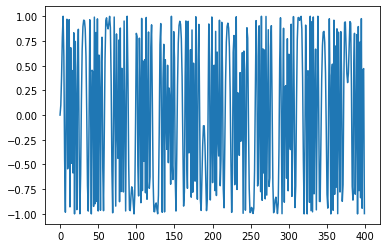

In [4]:
plt.plot(series)
plt.show()

In [5]:
# Setting up the data for time series prediction
T = 10 # Amount of values used to predict the next value
D = 1
X = [] # Holds the inputs
Y = [] # Holds the targets
for t in range((len(series))- T): # The length of N is equal to the total length of the data set minus the length of the time sequence
  x = series[t:t+T] # Holds a set of T values
  X.append(x) # Appends the set of T values to list X
  y = series[t+T] # Holds the target of the set of T values
  Y.append(y) # appends the target to list Y

X = np.array(X).reshape(-1, T) # Makes list X an array and sets the size to (N X T)
Y = np.array(Y) # Makes Y an array, no reshaping necessary as the lenth of Y is already equal to X
N = len(X) # Sets N to the length of array X
print('X.shape =', X.shape, ', Y.shape =',Y.shape)

X.shape = (390, 10) , Y.shape = (390,)


In [6]:
# Autoregressive linear model
i = Input(shape=(T,)) # (*, T) so it can take any N
x = Dense(1)(i) # Regression doesent use activation functions
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01)
)

r = model.fit(
    X[:-N//2], Y[:-N//2], # Train on the first half of the data
    epochs=125,
    validation_data=(X[-N//2:], Y[-N//2:]) # Validate on the second half of the data, as we are trying to be able to predict future data points in the data. So validating randomly would be less meaningful
    )

Train on 195 samples, validate on 195 samples
Epoch 1/125
195/195 [==============================] - 2s 9ms/sample - loss: 1.4714 - val_loss: 1.3758
Epoch 2/125
195/195 [==============================] - 0s 199us/sample - loss: 1.2542 - val_loss: 1.1786
Epoch 3/125
195/195 [==============================] - 0s 173us/sample - loss: 1.0841 - val_loss: 1.0229
Epoch 4/125
195/195 [==============================] - 0s 223us/sample - loss: 0.9493 - val_loss: 0.9050
Epoch 5/125
195/195 [==============================] - 0s 194us/sample - loss: 0.8422 - val_loss: 0.8127
Epoch 6/125
195/195 [==============================] - 0s 185us/sample - loss: 0.7598 - val_loss: 0.7390
Epoch 7/125
195/195 [==============================] - 0s 222us/sample - loss: 0.6940 - val_loss: 0.6845
Epoch 8/125
195/195 [==============================] - 0s 189us/sample - loss: 0.6472 - val_loss: 0.6425
Epoch 9/125
195/195 [==============================] - 0s 208us/sample - loss: 0.6102 - val_loss: 0.6086
Epoch 10/12

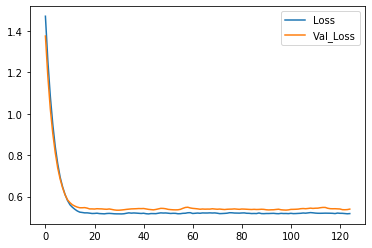

In [7]:
# Autoregressive Loss Per Iteration
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.show()

(390, 1)


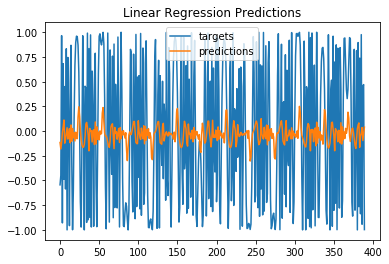

In [8]:
# One-Step forecast using true targets(Autoregressive)
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title('Linear Regression Predictions')
plt.legend()
plt.show()

In [0]:
# Forecast future values using only self predictions for making future predictions,(Not using the true targets)
validation_targets = Y[-N//2:]
validation_predictions = []

# Last Training input, begins where the validation set starts
last_x = X[-N//2]

while len(validation_predictions) < len(validation_targets):
  p = model.predict(last_x.reshape(1,-1))[0,0] # Model.predct returns N=Samples by K=Output Nodes output in this case it returns a matrix [1,1] so the first position [0,0] must be indexed to get the value

# Update Predictions List
  validation_predictions.append(p)

# Make the New Input
  last_x = np.roll(last_x, -1) # np.roll shifts the array. Negative values shift to the left, positive values shift to the right
  last_x[-1] = p

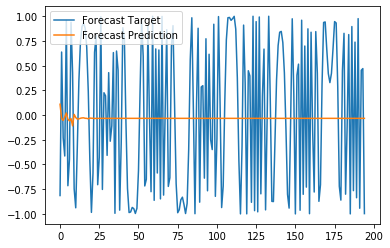

In [10]:
plt.plot(validation_targets, label ='Forecast Target')
plt.plot(validation_predictions, label='Forecast Prediction')
plt.legend()
plt.show()

In [11]:
# LSTM model
X = X.reshape(-1, T, 1) # Reshape into N X T X D for the RNN
i = Input(shape=(T,D))
x = LSTM(10)(i)
x = Dense(1)(x)

model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.05))

r = model.fit(X[:-N//2], Y[:-N//2], batch_size=32, epochs=205, validation_data=(X[-N//2:], Y[-N//2:]))

Train on 195 samples, validate on 195 samples
Epoch 1/205
195/195 [==============================] - 6s 32ms/sample - loss: 0.5412 - val_loss: 0.5426
Epoch 2/205
195/195 [==============================] - 0s 326us/sample - loss: 0.5272 - val_loss: 0.5391
Epoch 3/205
195/195 [==============================] - 0s 319us/sample - loss: 0.5261 - val_loss: 0.5394
Epoch 4/205
195/195 [==============================] - 0s 348us/sample - loss: 0.5220 - val_loss: 0.5414
Epoch 5/205
195/195 [==============================] - 0s 353us/sample - loss: 0.5221 - val_loss: 0.5413
Epoch 6/205
195/195 [==============================] - 0s 331us/sample - loss: 0.5223 - val_loss: 0.5403
Epoch 7/205
195/195 [==============================] - 0s 380us/sample - loss: 0.5193 - val_loss: 0.5367
Epoch 8/205
195/195 [==============================] - 0s 336us/sample - loss: 0.5220 - val_loss: 0.5348
Epoch 9/205
195/195 [==============================] - 0s 322us/sample - loss: 0.5176 - val_loss: 0.5296
Epoch 10/2

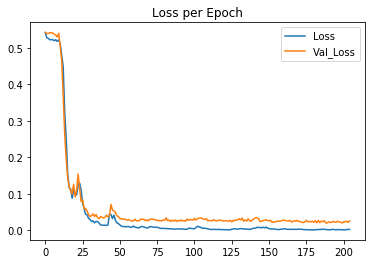

In [12]:
plt.plot(r.history['loss'], Label= 'Loss')
plt.plot(r.history['val_loss'], Label= 'Val_Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

(390, 1)


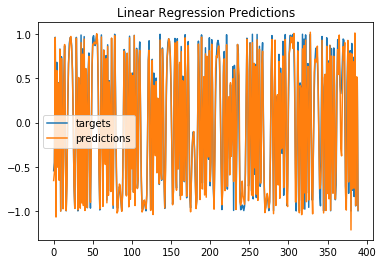

In [13]:
# One-Step forecast using true targets(LSTM)
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title('Linear Regression Predictions')
plt.legend()
plt.show()

In [0]:
# Forecast future values using only self predictions for making future predictions,(Not using the true targets)
validation_targets = Y[-N//2:]
validation_predictions = []

# Last Training input, begins where the validation set starts
last_x = X[-N//2]

while len(validation_predictions) < len(validation_targets):
  p = model.predict(last_x.reshape(1,T,1))[0,0] # Model.predct returns N=Samples by K=Output Nodes output in this case it returns a matrix [1,1] so the first position [0,0] must be indexed to get the value

# Update Predictions List
  validation_predictions.append(p)

# Make the New Input
  last_x = np.roll(last_x, -1) # np.roll shifts the array. Negative values shift to the left, positive values shift to the right
  last_x[-1] = p

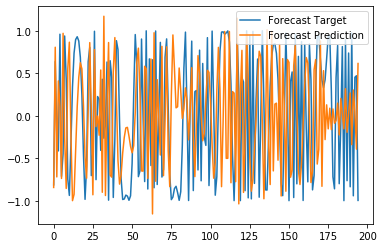

In [15]:
plt.plot(validation_targets, label ='Forecast Target')
plt.plot(validation_predictions, label='Forecast Prediction')
plt.legend()
plt.show()